# Spettro del Rubino

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modules import utils
import pandas as pd
import ast
import scipy as sp
from matplotlib import cm
%matplotlib widget

plt.close('all')

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,6901.060059,7000.0,1.008301,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6880.602539,7000.0,0.602539,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7002.104980,7300.0,1.504395,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7303.045410,7500.0,1.247559,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6890.741699,7050.0,0.643066,249
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,6890.643066,7050.0,0.641113,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,6890.416992,7015.0,0.419434,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,7000.602539,7180.0,0.600586,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,6890.716309,7015.0,0.417480,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,6951.498535,7100.0,0.498535,299


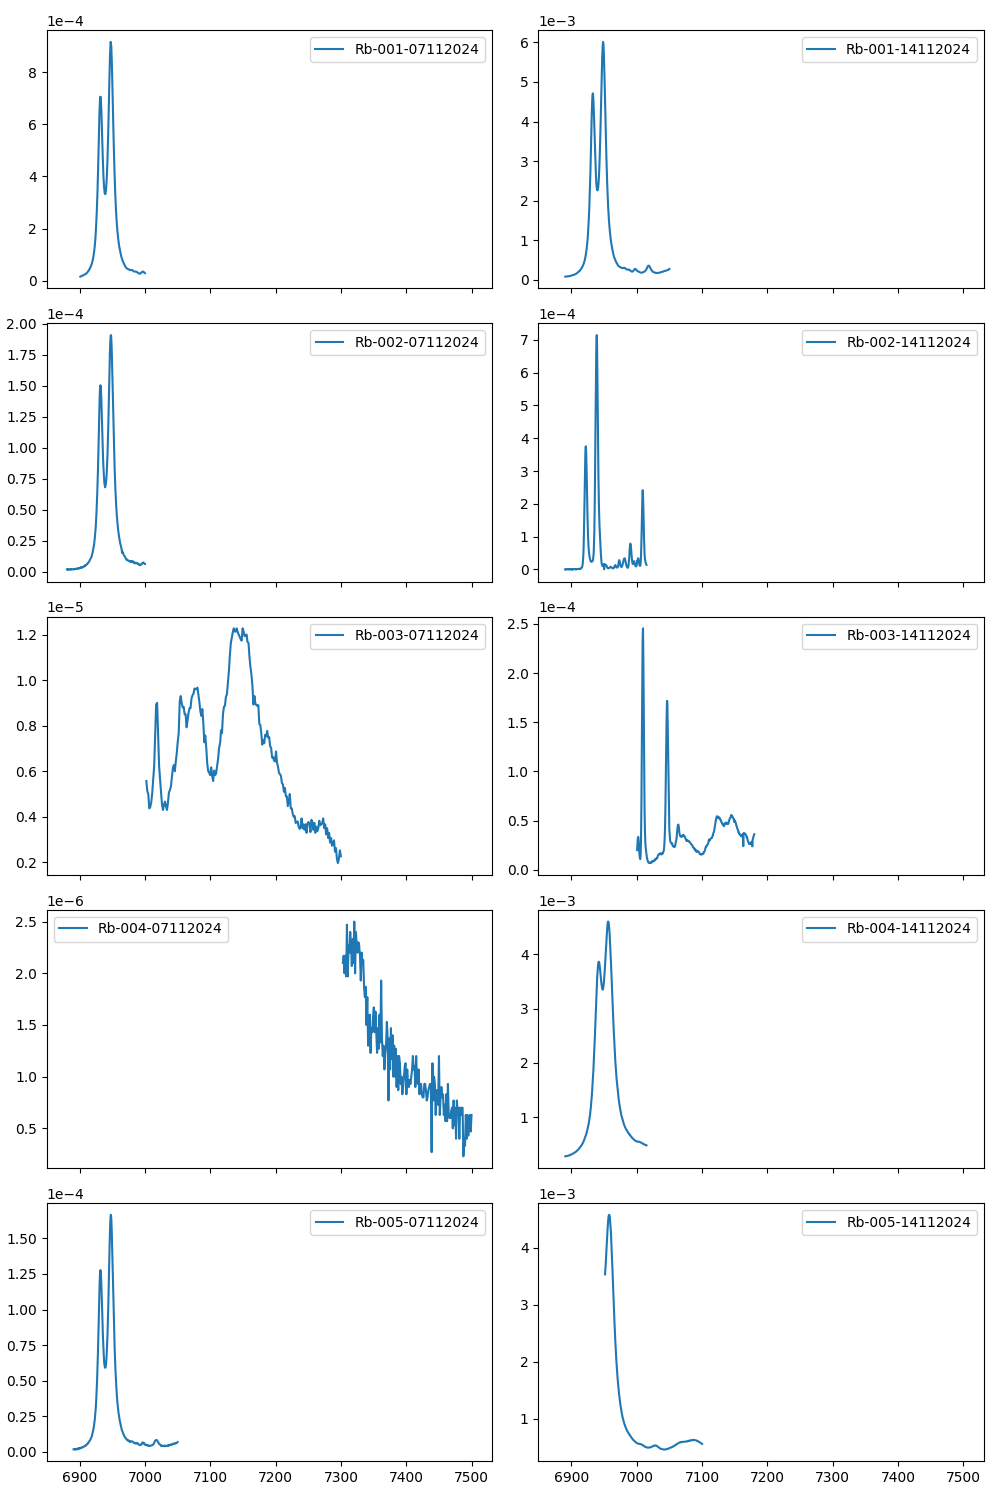

In [2]:
files = utils.getFiles('Raw_Data\\Rubidium_Spectrum')
files = [file for file in files if file.name.find('Rb_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

# sort it
df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# A quick look at the batch
fig, axs = plt.subplots(5, 2, sharex=True, figsize=(10, 15), layout='tight')
for i, row in df.iterrows():
    meta = ast.literal_eval(row['meta'])
    label = "-".join([meta.get(key) for key in ['type', 'id', 'date',]])
    axs[ i % 5, int(i / 5)].plot(row['wl'], row['mean'], label=label)
    
for ax in axs.flat:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
    ax.legend()
    
# generate the info table
info = df['meta'].apply(ast.literal_eval).apply(pd.Series)
info = info[['type', 'id', 'date'] + [col for col in info.columns if col not in ['type', 'id', 'date']]]
info['start'] = df['wl'].apply(lambda x: x[0])
info['stop'] = df['wl'].apply(lambda x: x[-1])
info['step'] = df['wl'].apply(lambda x: x[1] - x[0])
info['samples'] = df['wl'].apply(len)

info

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,6901.060059,7000.0,1.008301,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6880.602539,7000.0,0.602539,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7002.104980,7300.0,1.504395,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7303.045410,7500.0,1.247559,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6890.741699,7050.0,0.643066,249


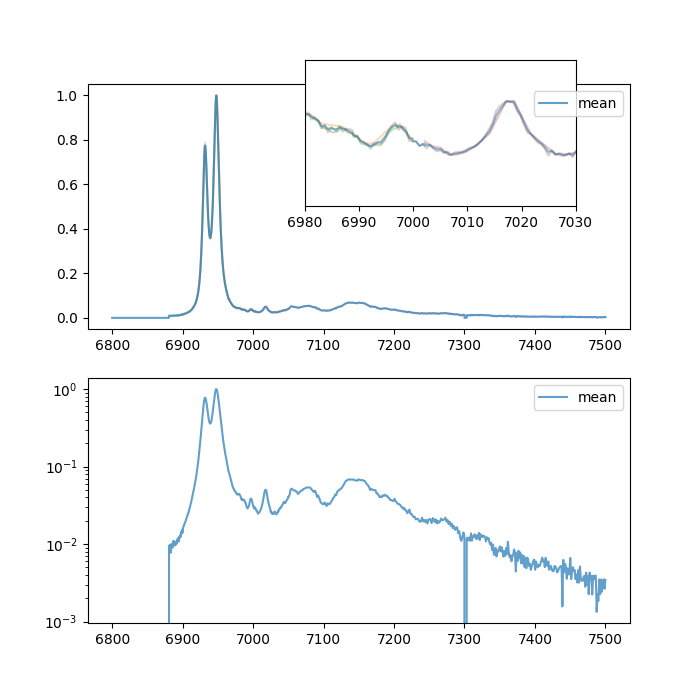

In [3]:
from scipy.interpolate import interp1d

def mean_overlap(comm_wl : np.ndarray, batch : pd.DataFrame):
    ''' 
    This function computes the mean of varius slices of
    batch over an interval
    '''
    
    # this is the result
    mean = np.zeros(len(comm_wl))
    
    # this counts the number of samples 
    # in each wl
    counts = np.zeros(len(comm_wl))
    
    for i, row in batch.iterrows():
        wl = row['int_wl']
        y = row['int_mean']
        min = np.argmax(comm_wl >= wl.min())
        max = np.argmax(comm_wl > wl.max())
        
        # if the max is 0, it means that the wl is larger than the maximum
        if max == 0:
            max = len(comm_wl)

        mean[min:max]  =  mean[min:max] + y
        counts[min:max] = counts[min:max] + 1
    
    mean = np.divide(mean, counts, out=np.zeros_like(mean), where=counts!=0)
    return mean

def myinterp(series, x_new):
    # extract the x and y values
    x = series['wl']
    y = series['mean']
    
    # keep only the values that are within the range
    mask = np.logical_and(x_new > x.min(), x_new < x.max())
    x_new = x_new[mask]
    
    # return both the new x and the interpolated values
    f = interp1d(x, y, kind='linear')
    return x_new, f(x_new)

def interpolate_batch(batch, common_wl):
    ''' 
    If normalization is not given divide by the maximum value
    '''    
    # interpolate the batch
    batch['interp'] = batch.apply(myinterp, x_new = common_wl, axis=1).to_numpy()
    batch['int_wl'] = batch['interp'].apply(lambda x: x[0])
    batch['int_mean'] = batch['interp'].apply(lambda x: x[1])

    common_mean = mean_overlap(common_wl, batch)
    return common_mean

def plot_interp_batch(batch, common_wl, common_mean):
    fig, axs = plt.subplots(2, 1, figsize=(7, 7))
    # inset 
    inset = axs[0].inset_axes([0.4, 0.5, 0.5, 0.6])
    inset.set_xlim(6980, 7030)
    inset.set_ylim(0, .07)
    inset.set(yticks=[])
    
    # plot the mean
    axs[0].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
    inset.plot(common_wl, common_mean, label='mean', alpha = 0.5, zorder = 2)

    # plot the interpolated batch
    batch['interp'].apply(lambda x: axs[0].plot(x[0], x[1], alpha=0.2, zorder = 1))
    batch['interp'].apply(lambda x: inset.plot(x[0], x[1], alpha=0.3, zorder = 1))

    # plot a clean result in log scale
    axs[1].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
    axs[1].set_yscale('log')

    for ax in axs.flat:
        ax.legend()  
    return axs

def normalize(series : pd.Series , ids : list, norm = None):
    if not (series['id'] in ids):
        return series
    
    if norm is None:
        norm = series['mean'].max()
   
    series['mean'] = series['mean'] / norm
    return series

# @ room temperature
mask = df['date'] == '07112024' 
batch_0 = df[mask]
display(info[mask])
  
batch_0 = batch_0.apply(normalize, ids = ['001', '002', '005'] ,  axis=1)
batch_0 = batch_0.apply(normalize, ids = ['003', '004'] ,  axis=1, norm = 0.000179)

common_wl = np.arange(6800, 7500, 0.1)
common_mean = interpolate_batch(batch_0, common_wl)

axs = plot_interp_batch(batch_0, common_wl, common_mean)

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,6890.643066,7050.0,0.641113,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,6890.416992,7015.0,0.419434,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,7000.602539,7180.0,0.600586,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,6890.716309,7015.0,0.417480,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,6951.498535,7100.0,0.498535,299


C:\Users\alber\AppData\Local\Temp\ipykernel_15848\1568856668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp'] = info.loc[mask, 'temp'].values
C:\Users\alber\AppData\Local\Temp\ipykernel_15848\1568856668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
C:\Users\alber\AppData\Local\Temp\ipykernel_15848\1568856668.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

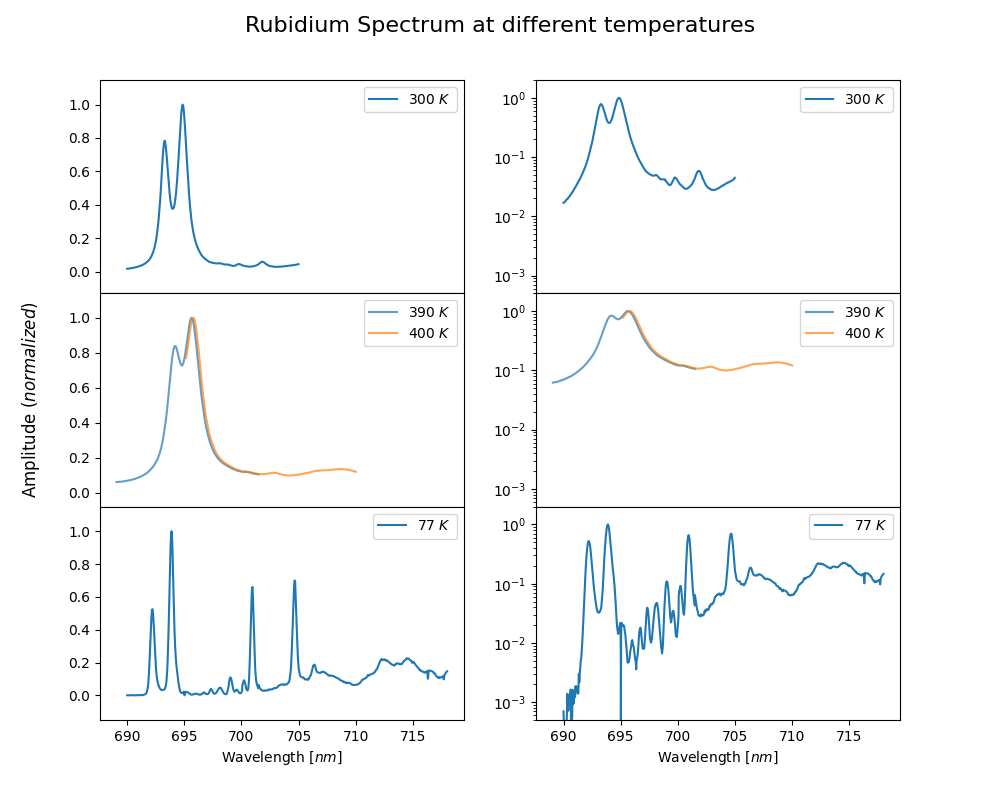

In [4]:
mask = df['date'] == '14112024' 
batch_0 = df[mask]
display(info[mask])

# add the temperature
batch_0['temp'] = info.loc[mask, 'temp'].values

# HACk
batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
batch_0['temp'] = ['300K', '77K', '77K', '390K', '400K']
ids = ['001', '002', '003', '004', '005']

common_wl = np.arange(6900, 7200, 0.1)

fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex=True)
i = 0
for gid, group in batch_0.groupby('temp_groups'):

    # normalize the group
    group = group.apply(normalize, axis=1, ids = ids)

    # interpolate the group    
    if gid == '400K':
        group.apply(lambda x: axs[i, 0].plot(x['wl'] / 10, x['mean'], alpha=0.7, 
                                             label = r'${}\ K$'.format(x['temp'][:-1])), axis=1)
        group.apply(lambda x: axs[i, 1].plot(x['wl'] / 10, x['mean'], alpha=0.7, 
                                             label = r'${}\ K$'.format(x['temp'][:-1])), axis=1)
    else:
        label = r'${}\ K$'.format(gid[:-1])
        common_mean = interpolate_batch(group, common_wl)
        # plot
        mask = common_mean > 0
        axs[i, 0].plot(common_wl[mask] / 10, common_mean[mask], label=label)
        axs[i, 1].plot(common_wl[mask] / 10, common_mean[mask], label=label)
        
    axs[i, 0].margins(y=0.15)
    axs[i, 1].set_ylim(5e-4, 2)
    axs[i, 1].set_yticks([1e-3, 1e-2, 1e-1, 1])
    axs[i, 1].margins(y=0.15)
    axs[i, 1].set_yscale('log')
    i = i + 1

fig.subplots_adjust(hspace=0, left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.supylabel('Amplitude $(normalized)$')
fig.suptitle('Rubidium Spectrum at different temperatures', fontsize=16)

# common_mean = interpolate_batch(batch_0, common_wl)
for ax in axs.flat:
    ax.set_xlabel('Wavelength $[nm]$')
    ax.legend()

In [5]:
figures = {num: plt.figure(num) for num in plt.get_fignums()}
print(figures)

{1: <Figure size 1500x2250 with 10 Axes>, 2: <Figure size 1050x1050 with 2 Axes>, 3: <Figure size 1500x1200 with 6 Axes>}


In [6]:
from ipywidgets import FloatRangeSlider, FloatLogSlider, AppLayout, interactive, VBox, Output


cm = plt.get_cmap('tab10')
with plt.ioff():
    fig, ax = plt.subplots(figsize=(8, 5))    
    

def find_peaks(prominence=6e-7, width=(1, 20)):
    '''This function will be turned into a widget'''
    ax.clear()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_yscale('log')
    
    label = 'mean'
    ax.plot(comm_wl, comm_mean, label=label)
    step = comm_wl[1] - comm_wl[0]
    width = (width[0] / step, width[1] / step)
    peaks, properties = sp.signal.find_peaks(comm_mean, prominence=prominence, width=width)
    if len(peaks) == 0:
        return

    res_full = sp.signal.peak_widths(comm_mean, peaks, rel_height=.5)
    # HACK: for some reason res_full[1:] is treathed as a tuple
    y, xmin, xmax = res_full[1:]
    
    # resize the values to data space
    step = comm_wl[1] - comm_wl[0]
    xmin = comm_wl[0] + step * xmin
    xmax = comm_wl[0] + step * xmax
        
    # add the peaks to the results
    results = peaks

    # draw the peaks
    ax.plot(comm_wl[peaks], comm_mean[peaks], "x", alpha=0.5)
    ax.vlines(x=comm_wl[peaks], ymin=comm_mean[peaks] - properties["prominences"],
                    ymax = comm_mean[peaks], alpha=0.5)  
    ax.hlines(y=y, xmin=xmin, xmax=xmax, alpha=0.5)
    
    ax.legend()
    return results


# widget to find peaks
prominance = FloatLogSlider(value=1.22e-6, base=10, min=-8, max=1, step=0.01, readout_format='.3e', continuous_update=False)
width = FloatRangeSlider(value=(1, 20), min=0, max=50, step=.1, readout_format='.1f', continuous_update=False)
w = interactive(find_peaks, prominence=prominance, width=width, continuous_update=False)
out = Output()
result = Output()
with out:
    display(info)
with result:
    display(w.result)

AppLayout(
    center=fig.canvas,
    right_sidebar=VBox([w, result]),
    footer = out,
    pane_widths=[0, 2, 1]
)

AppLayout(children=(Output(layout=Layout(grid_area='footer')), VBox(children=(interactive(children=(FloatLogSl…

In [7]:
peaks = w.result
peaks